# LOSO Training Example
This notebook demonstrates how to use the LOSO training framework for Human Activity Recognition.

## 1. Imports and Setup

In [2]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add paths
sys.path.insert(0, os.path.abspath("."))

from utils.dataset_loader import LOSOSplitter, create_dataloaders
from utils.training_utils import Trainer, compute_metrics, save_model, load_model
from models.MobileViT import MobileViT
from models.DeepConvLSTM import DeepConvLSTM

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore Data

In [3]:
# Initialize LOSO splitter
splitter = LOSOSplitter('dataset/processed_acc_gyr')

print(f"Dataset shape: {splitter.X.shape}")
print(f"Labels shape: {splitter.y.shape}")
print(f"Number of subjects: {len(splitter.subjects)}")
print(f"Subjects: {splitter.subjects}")

Loaded dataset: X.shape=(31863, 200, 6), y.shape=(31863,)
Number of subjects: 15
Subjects: ['1proband', '2proband', '3proband', '4proband', '5proband', '6proband', '7proband', '8proband', '9proband', '10proband', '11proband', '12proband', '13proband', '14proband', '15proband']
Dataset shape: (31863, 200, 6)
Labels shape: (31863,)
Number of subjects: 15
Subjects: ['1proband', '2proband', '3proband', '4proband', '5proband', '6proband', '7proband', '8proband', '9proband', '10proband', '11proband', '12proband', '13proband', '14proband', '15proband']


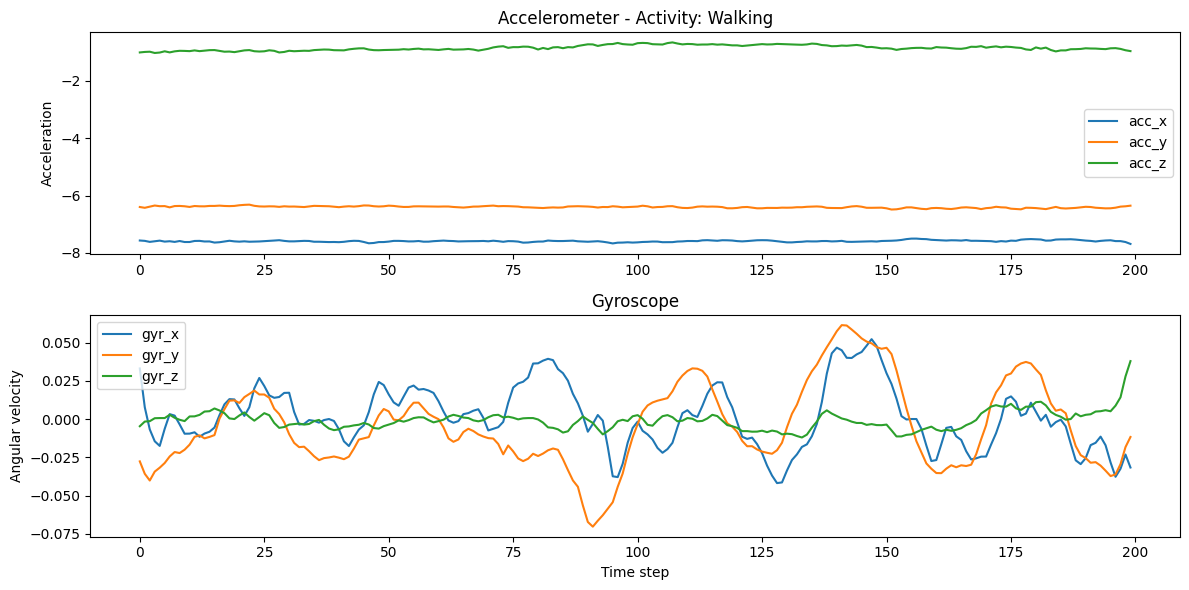

In [4]:
# Visualize a sample window
sample_idx = 0
sample_window = splitter.X[sample_idx]
sample_label = splitter.y[sample_idx]

activity_names = [
    "Walking",
    "Running",
    "Sitting",
    "Standing",
    "Lying",
    "ClimbingUp",
    "ClimbingDown",
    "Jumping",
]

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(sample_window[:, :3])
axes[0].set_title(f"Accelerometer - Activity: {activity_names[sample_label]}")
axes[0].legend(["acc_x", "acc_y", "acc_z"])
axes[0].set_ylabel("Acceleration")

axes[1].plot(sample_window[:, 3:])
axes[1].set_title("Gyroscope")
axes[1].legend(["gyr_x", "gyr_y", "gyr_z"])
axes[1].set_ylabel("Angular velocity")
axes[1].set_xlabel("Time step")

plt.tight_layout()
plt.show()

## 3. Train a Single LOSO Fold (Example)

In [5]:
# Get train/test split for one subject
test_subject = "1proband"
X_train, y_train, X_test, y_test = splitter.get_train_test_split(test_subject)

print(f"Test subject: {test_subject}")
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Test subject: 1proband
Train set: (29805, 200, 6), (29805,)
Test set: (2058, 200, 6), (2058,)


In [6]:
# Create data loaders
train_loader, test_loader, norm_stats = create_dataloaders(
    X_train, y_train, X_test, y_test, batch_size=32, num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 932
Test batches: 65


In [7]:
# Create MobileViT model
config = {
    "window_size": 200,
    "nb_channels": 6,
    "nb_classes": 8,
    "dims": [32, 64, 96, 128],
    "num_transformer_layers": [2, 4],
    "patch_size": 2,
    "num_heads": 4,
    "dropout": 0.1,
}

model = MobileViT(config)
print(f"Model parameters: {model.number_of_parameters():,}")

Model parameters: 1,076,808


In [8]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, device, criterion, optimizer)

# Train for a few epochs (use more for better results)
history = trainer.train(train_loader, test_loader, epochs=10, verbose=True)

Epoch 1/10 - Train Loss: 0.8074, Train Acc: 0.7310 | Val Loss: 1.0870, Val Acc: 0.6550 ✓ BEST


Epoch 2/10 - Train Loss: 0.6136, Train Acc: 0.8009 | Val Loss: 0.9098, Val Acc: 0.6759 ✓ BEST


KeyboardInterrupt: 

## 4. Evaluate and Visualize

In [10]:
# Final evaluation
test_loss, test_acc, y_pred, y_true = trainer.validate(test_loader)

print(f"Test Accuracy: {test_acc:.4f}")

# Compute detailed metrics
metrics = compute_metrics(y_true, y_pred, num_classes=8)
print(f"F1-Macro: {metrics['f1_macro']:.4f}")
print(f"F1-Weighted: {metrics['f1_weighted']:.4f}")

Test Accuracy: 0.9864
F1-Macro: 0.9866
F1-Weighted: 0.9865


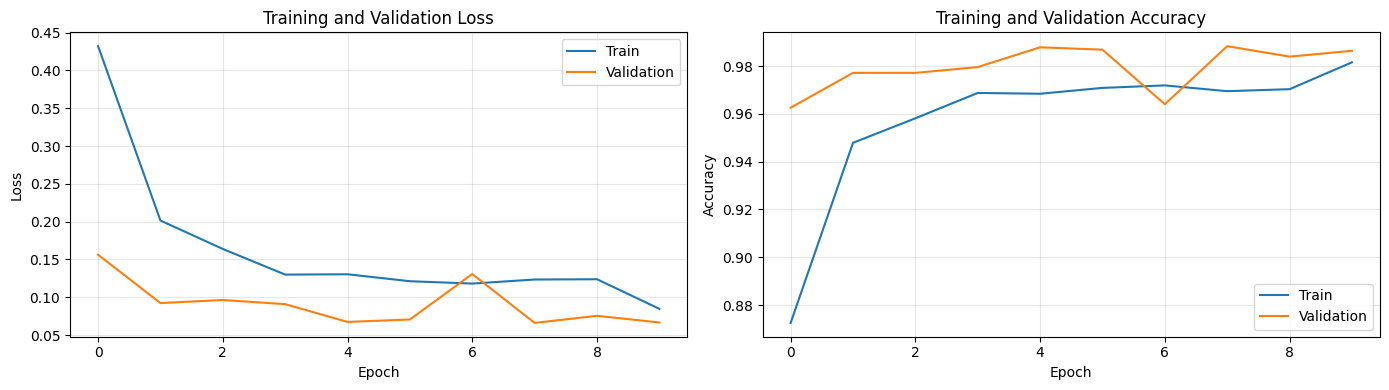

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves
axes[0].plot(history["train_losses"], label="Train")
axes[0].plot(history["val_losses"], label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history["train_accs"], label="Train")
axes[1].plot(history["val_accs"], label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

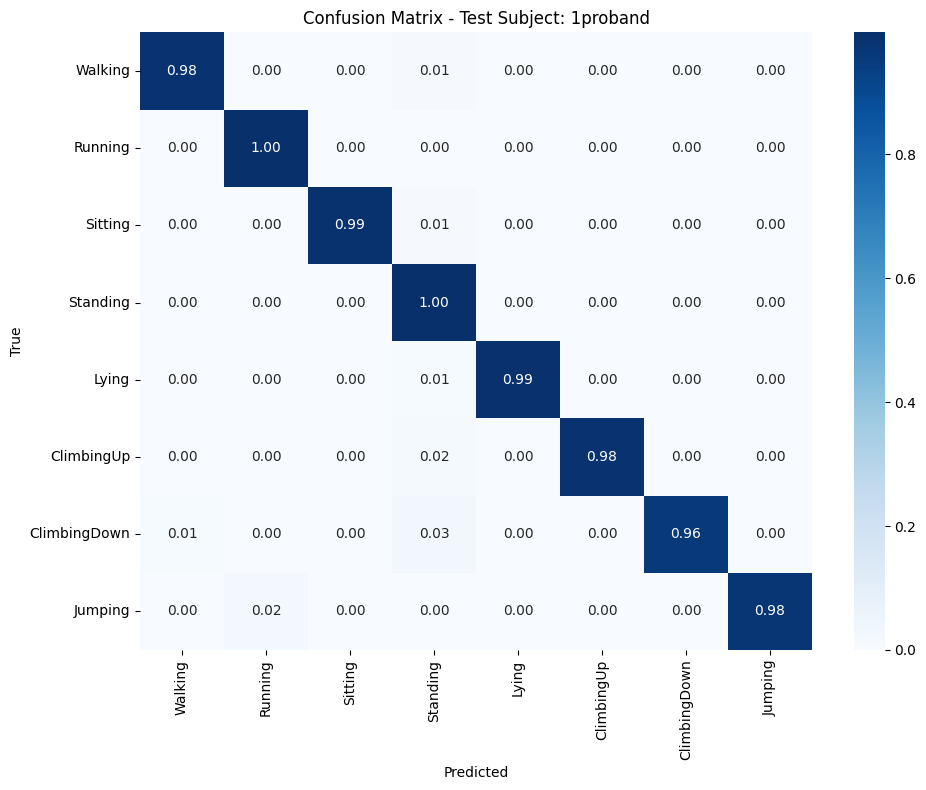

In [12]:
# Plot confusion matrix
import seaborn as sns

cm = np.array(metrics["confusion_matrix"])
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=activity_names,
    yticklabels=activity_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Test Subject: {test_subject}")
plt.tight_layout()
plt.show()

In [17]:
save_model(model, "mobilevit_loso_1proband.pth")

## 5. Run Full LOSO (Optional)

For full LOSO cross-validation, use the command-line script:

```bash
python train_loso.py --model mobilevit --epochs 50 --batch_size 32
```

Or use the batch script:
```bash
run_training.bat mobilevit 50 32
```